### 5.	Caso Práctico

Como Científico de Datos usted debe comprender el comportamiento de los clientes, segmentarlos, estar en capacidad de presentarle a la alta gerencia de la compañía sus hallazgos y emplear modelos analíticos para determinar qué campañas se deberán hacer para mejorar la rentabilidad de los clientes.
Para el siguiente caso práctico, usted deberá trabajar con datos reales de unas campañas se telemercadeo de un banco portugués.
El objetivo del ejercicio es analizar la base de clientes, estimar un modelo de predicción de clientes que deben ser seleccionados en cada campaña y con base en este proponer la estrategia sobre la cual se deben realizar las campañas de este producto.
La base de datos la puede descargar de http://archive.ics.uci.edu/dataset/222/bank+marketing usar el conjunto de datos “bank-full.csv”. de la carpeta bank.zip 

El entregable de este ejercicio es una presentación que cubra los siguientes aspectos:
Capítulo técnico (Asuma que lo presentaría ante un público técnico con amplios conocimientos estadísticos, de ciencia de datos y machine learning):
1.	Análisis descriptivo de la población
2.	Modelo de predicción seleccionado:
    - Justificación de la metodología de modelamiento seleccionada
    - Presentar métricas de clasificación (Puede usar el criterio de área bajo la curva ROC o los criterios que considere convenientes)

Capítulo de Negocio (Asuma que lo presentará ante gerentes de negocio, con un buen entendimiento de los clientes, pero bajo conocimiento técnico):

1.	Principales hallazgos y conclusiones
2.	Propuesta de estrategia para seleccionar los clientes buscando el mayor impacto con el menor costo posible.



In [49]:
## Librerias base 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import sys 
import os
import warnings
import optuna
from IPython.display import display, Markdown
warnings.filterwarnings("ignore")


## Modulo para preprocesadores de los datos
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler

## Modulo para evaluacion, split y construccion pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split




## Modulo de algoritmos para entrenamiento
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Configuración de estilo para Seaborn
sns.set_theme(style="darkgrid")

sys.path.append(os.path.abspath(".."))

In [4]:
df = pd.read_csv('/Users/santiagovasquezr/Documents/datecsa/data/csv/bank-full.csv',delimiter=";")

## 1. Analisis exploratorio.
### En ese inciso se desea obtener información relevante sobre el comportamiento del usuario y entender cuales son las caracteristicas de los usuarios que eligen ciertas campañas y cuales de ellos deben ser seleccionados para dichas campañas

In [7]:
print("\nResumen del dataset:")
print(df.info())


Resumen del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None


Basados en la descripción de las variables se puede intuir que las variables de 'day', 'campaign', 'pdays' & 'previous' si bien tiene una naturaleza de ser nunerica, son numericas discretas lo cual hace pensar que podrian tratarse como categorias dentro del analisis debido a que tienen un número "finito" de posibilidades. De tal manera que, para efectos del analisis estas variables seran tomadas como categorias. 

In [65]:
#df['day'] = df['day'].astype(object)
#df['campaign'] = df['campaign'].astype(object)
#df['pdays'] = df['pdays'].astype(object)
#df['previous'] = df['previous'].astype(object)

In [66]:
print("\nEstadísticas descriptivas:")
print(df.describe())


Estadísticas descriptivas:
                age        balance      duration
count  45211.000000   45211.000000  45211.000000
mean      40.936210    1362.272058    258.163080
std       10.618762    3044.765829    257.527812
min       18.000000   -8019.000000      0.000000
25%       33.000000      72.000000    103.000000
50%       39.000000     448.000000    180.000000
75%       48.000000    1428.000000    319.000000
max       95.000000  102127.000000   4918.000000


In [67]:
print("\nTotal Valores Nulos por feature:")
print(df.isnull().sum())


Total Valores Nulos por feature:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


### Se tiene un alta completitud en los datos

## A continuación queremos analizar el comportamiento de nuestra variable target

## Se puede observar que el numero de usuario que toman la suscripcón es bajo respecto a los que si la toman, esto de entrada nos habla de un desbalance fuerte en los datos.

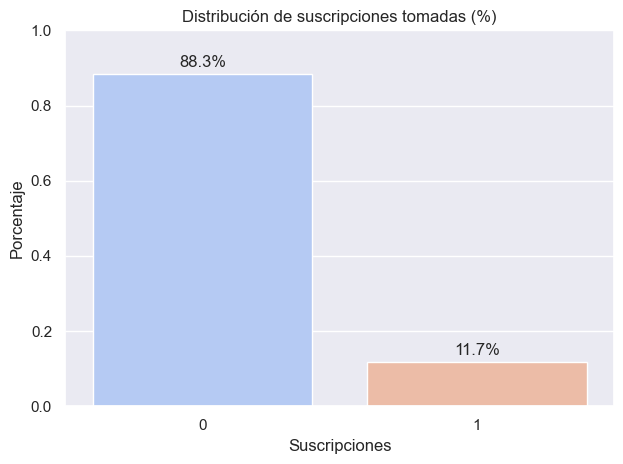

In [35]:
# Calcular proporciones manualmente
prop_df = df['y'].value_counts(normalize=True).reset_index()
prop_df.columns = ['y', 'percentage']

# Graficar
sns.barplot(data=prop_df, x='y', y='percentage', palette='coolwarm')
plt.title('Distribución de suscripciones tomadas (%)')
plt.ylabel('Porcentaje')
plt.xlabel('Suscripciones')
plt.ylim(0, 1)

# Mostrar porcentajes encima
for index, row in prop_df.iterrows():
    plt.text(index, row.percentage + 0.02, f'{row.percentage:.1%}', ha='center')

plt.tight_layout()
plt.show()


In [52]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
numerical_columns = df.select_dtypes(exclude=['object', 'category']).columns

In [ ]:
tmp = df[df['y']==1]
tmp.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.0
mean,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354,1.0
std,13.497781,3501.104777,8.501875,392.525262,1.921826,118.822266,2.553272,0.0
min,18.000000,-3058.000000,1.000000,8.000000,1.000000,-1.000000,0.000000,1.0
25%,31.000000,210.000000,8.000000,244.000000,1.000000,-1.000000,0.000000,1.0
50%,38.000000,733.000000,15.000000,426.000000,2.000000,-1.000000,0.000000,1.0
75%,50.000000,2159.000000,22.000000,725.000000,3.000000,98.000000,1.000000,1.0
max,95.000000,81204.000000,31.000000,3881.000000,32.000000,854.000000,58.000000,1.0


In [59]:
tmp1 = df[df['y']==0]
tmp1.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,39922.000000,39922.000000,39922.000000,39922.000000,39922.000000,39922.000000,39922.000000,39922.0
mean,40.838986,1303.714969,15.892290,221.182806,2.846350,36.421372,0.502154,0.0
std,10.172662,2974.195473,8.294728,207.383237,3.212767,96.757135,2.256771,0.0
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.0
25%,33.000000,58.000000,8.000000,95.000000,1.000000,-1.000000,0.000000,0.0
50%,39.000000,417.000000,16.000000,164.000000,2.000000,-1.000000,0.000000,0.0
75%,48.000000,1345.000000,21.000000,279.000000,3.000000,-1.000000,0.000000,0.0
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,0.0


In [50]:
for column in categorical_columns:
    counts = tmp[column].value_counts()
    percentages = tmp[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({
        'Frecuencia': counts,
        'Porcentaje (%)': percentages.round(2)
    })

    display(Markdown(f"### Distribución de valores para **{column}**"))
    display(summary)


### Distribución de valores para **job**

,Frecuencia,Porcentaje (%)
job,,
management,1301,24.60
technician,840,15.88
blue-collar,708,13.39
admin.,631,11.93
retired,516,9.76
services,369,6.98
student,269,5.09
unemployed,202,3.82
self-employed,187,3.54


### Distribución de valores para **marital**

,Frecuencia,Porcentaje (%)
marital,,
married,2755,52.09
single,1912,36.15
divorced,622,11.76


### Distribución de valores para **education**

,Frecuencia,Porcentaje (%)
education,,
secondary,2450,46.32
tertiary,1996,37.74
primary,591,11.17
unknown,252,4.76


### Distribución de valores para **default**

,Frecuencia,Porcentaje (%)
default,,
no,5237,99.02
yes,52,0.98


### Distribución de valores para **housing**

,Frecuencia,Porcentaje (%)
housing,,
no,3354,63.41
yes,1935,36.59


### Distribución de valores para **loan**

,Frecuencia,Porcentaje (%)
loan,,
no,4805,90.85
yes,484,9.15


### Distribución de valores para **contact**

,Frecuencia,Porcentaje (%)
contact,,
cellular,4369,82.61
unknown,530,10.02
telephone,390,7.37


### Distribución de valores para **month**

,Frecuencia,Porcentaje (%)
month,,
may,925,17.49
aug,688,13.01
jul,627,11.85
apr,577,10.91
jun,546,10.32
feb,441,8.34
nov,403,7.62
oct,323,6.11
sep,269,5.09


### Distribución de valores para **poutcome**

,Frecuencia,Porcentaje (%)
poutcome,,
unknown,3386,64.02
success,978,18.49
failure,618,11.68
other,307,5.80


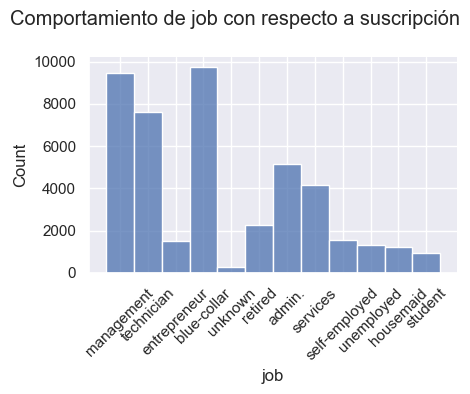

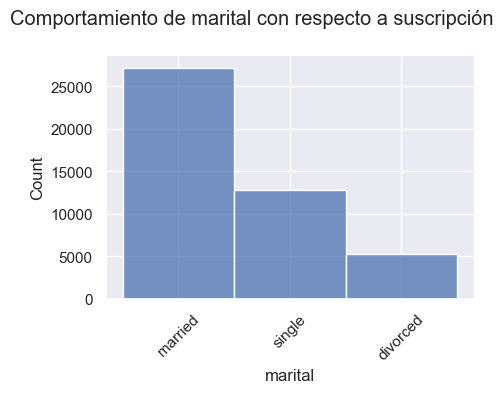

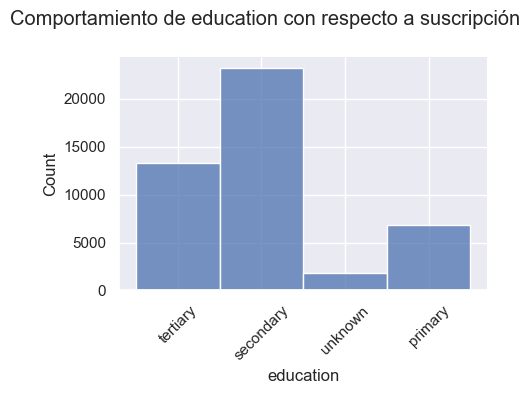

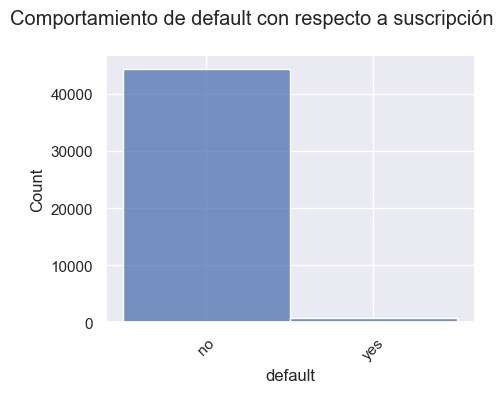

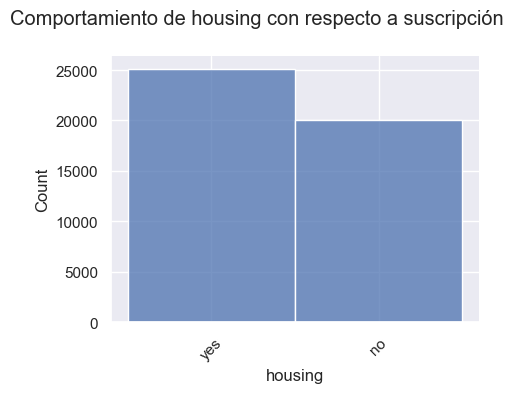

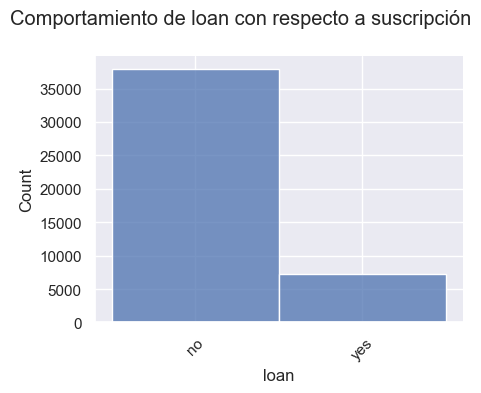

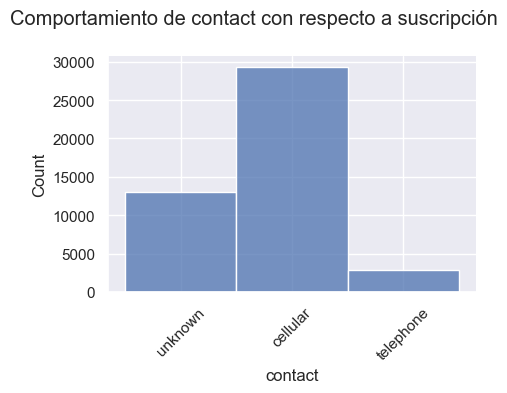

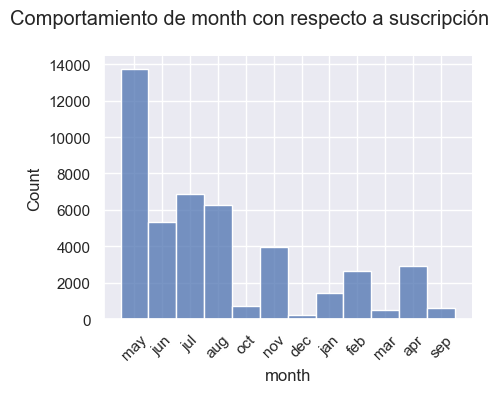

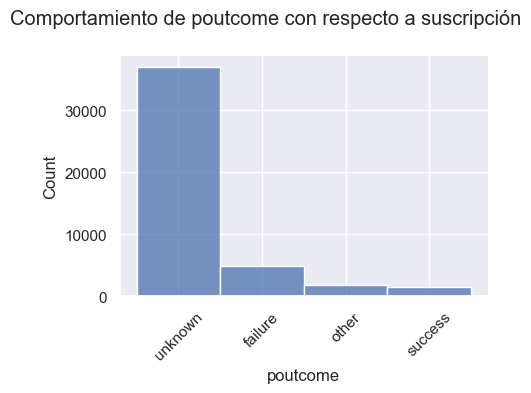

In [ ]:
# Loop por cada columna para crear los catplot
for column in categorical_columns:
    g = sns.displot(data=df,x=column,palette='rocket',height=4,aspect=1.2)
    g.fig.suptitle(f'Comportamiento de {column} con respecto a suscripción')
    g.set_xticklabels(rotation=45)
    if g._legend:
        g._legend.set_title("Suscripción")

    plt.tight_layout()
    plt.show()

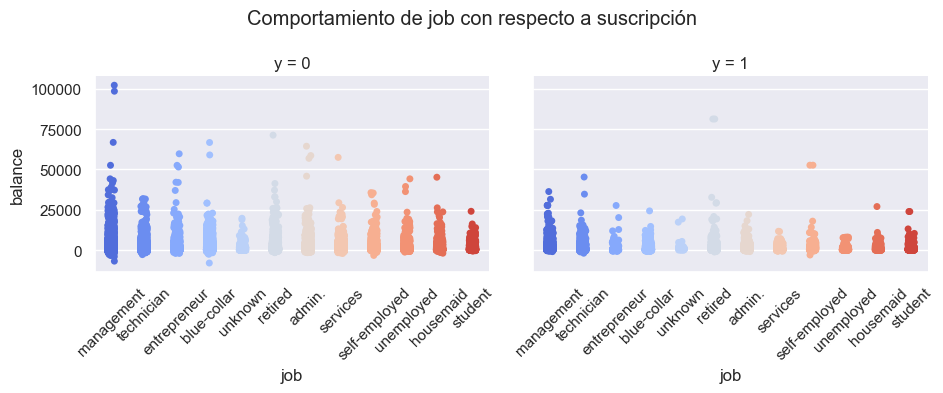

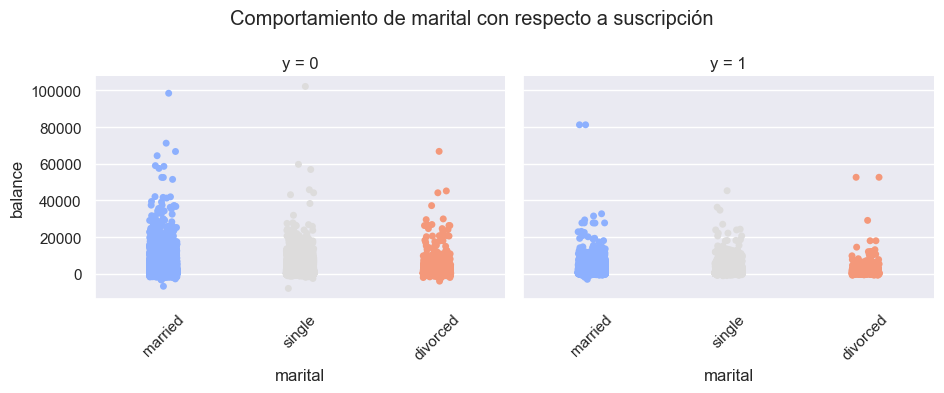

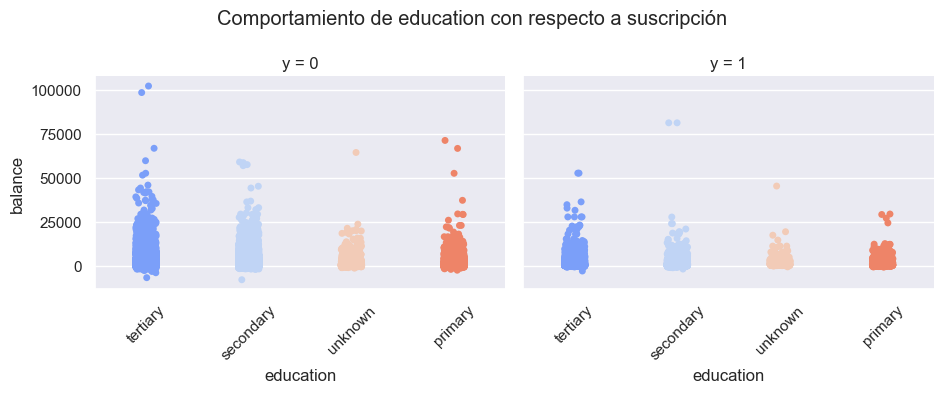

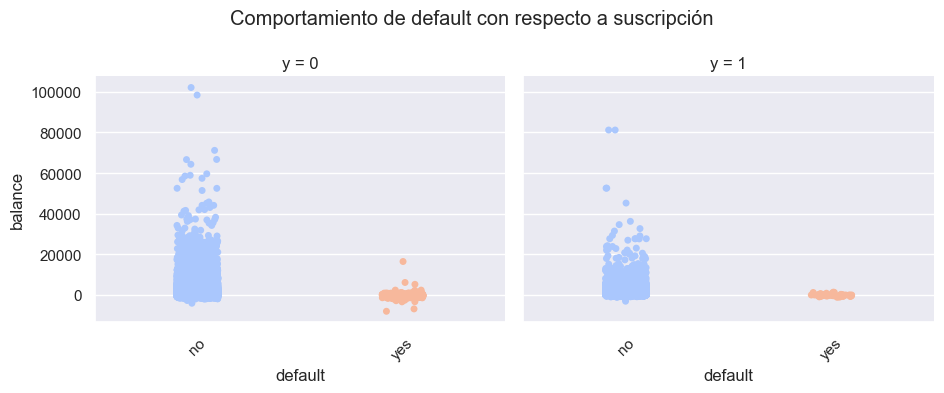

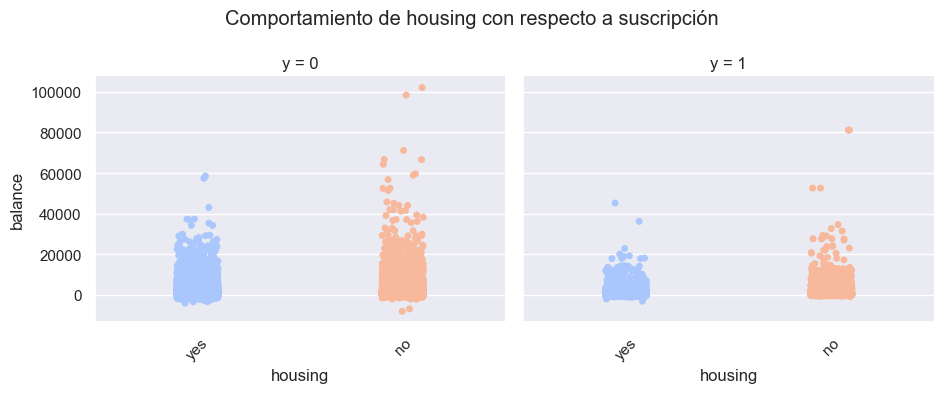

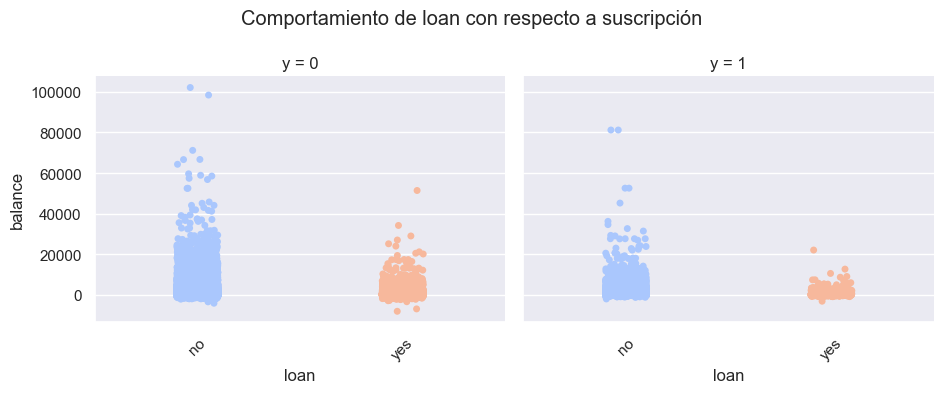

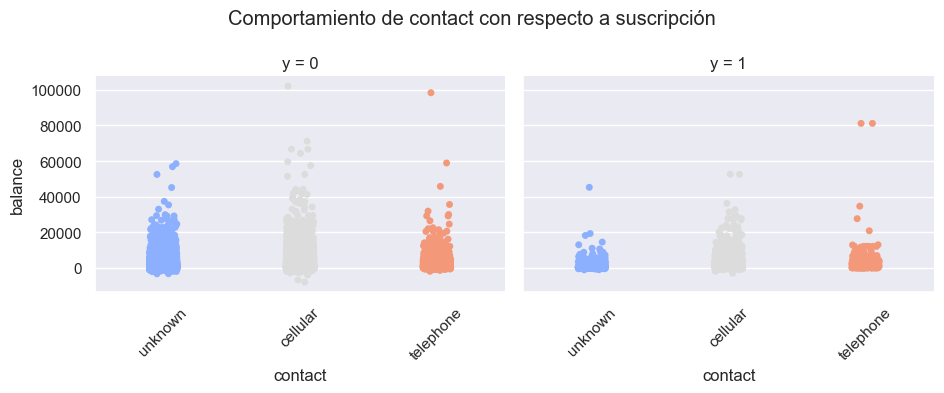

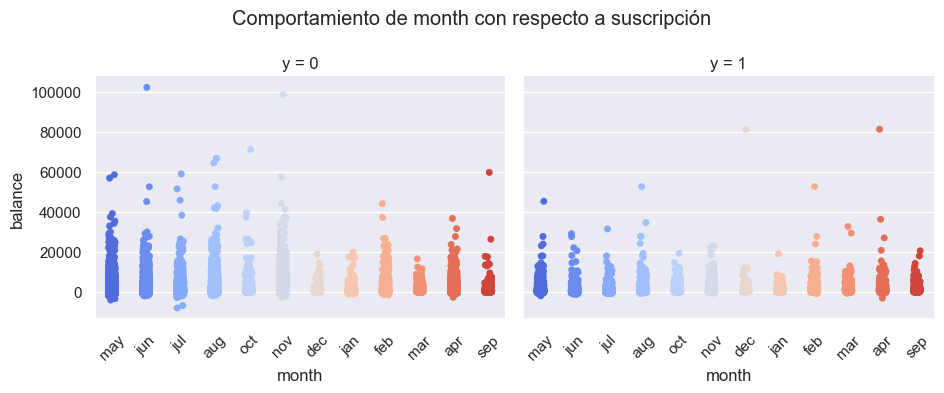

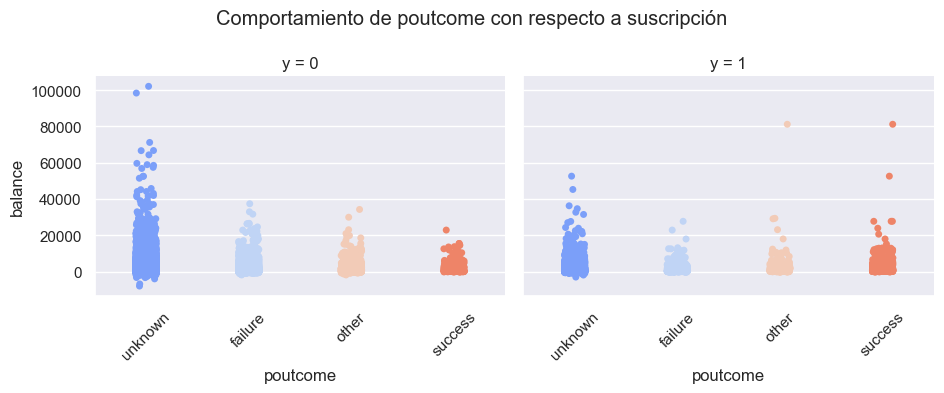

In [ ]:
# Seleccionar columnas categóricas sin la columna objetivo
categorical_columns = [col for col in categorical_columns if col != 'y']

# Loop por cada columna para crear los catplot
for column in categorical_columns:
    g = sns.catplot(data=df,x=column,y="balance",col='y',palette='coolwarm',height=4,aspect=1.2)
    
    g.fig.suptitle(f'Comportamiento de {column} con respecto a suscripción')
    g.set_xticklabels(rotation=45)
    if g._legend:
        g._legend.set_title("Suscripción")

    plt.tight_layout()
    plt.show()


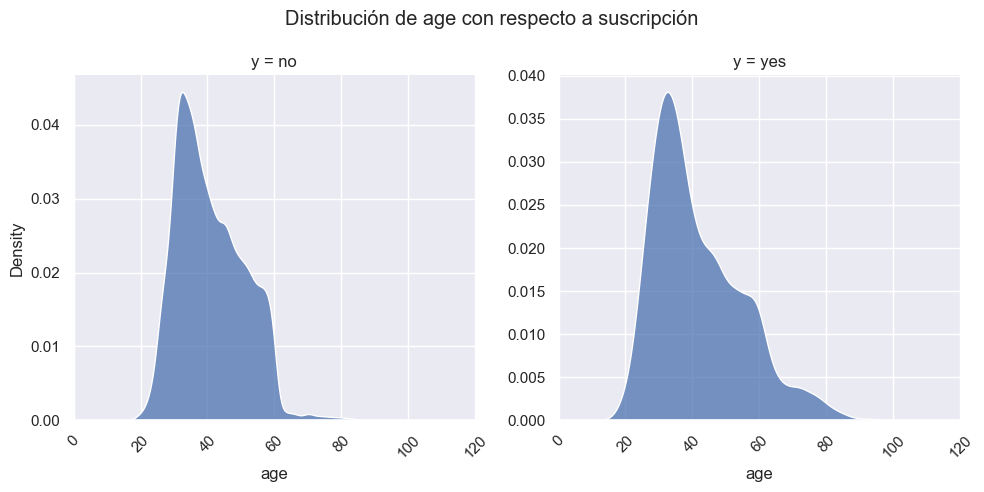

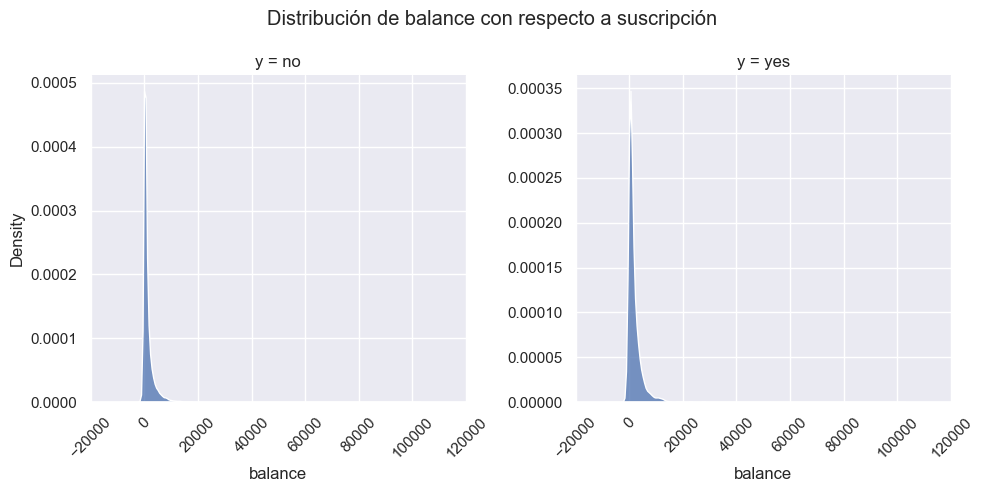

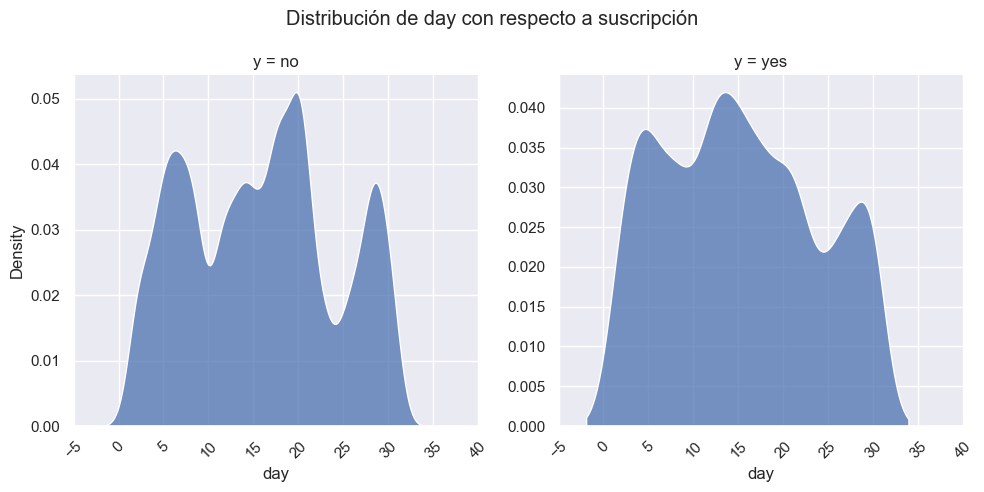

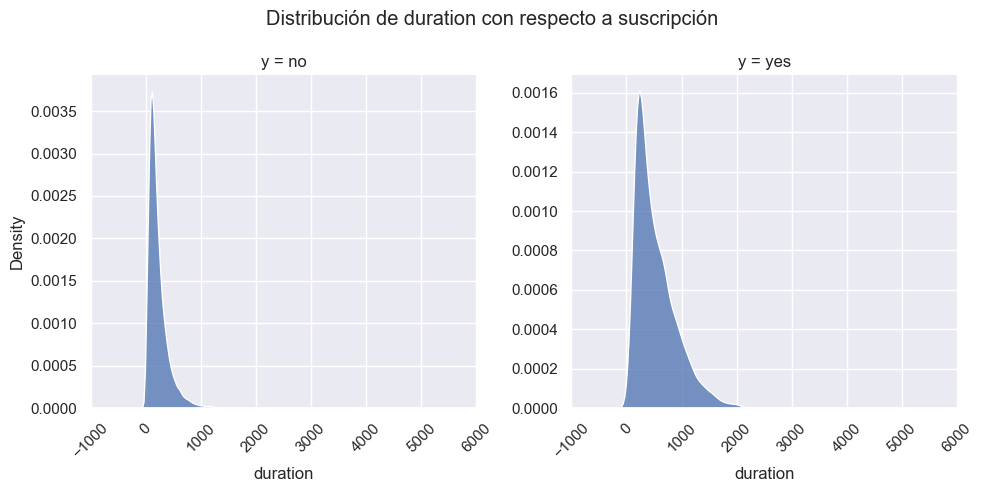

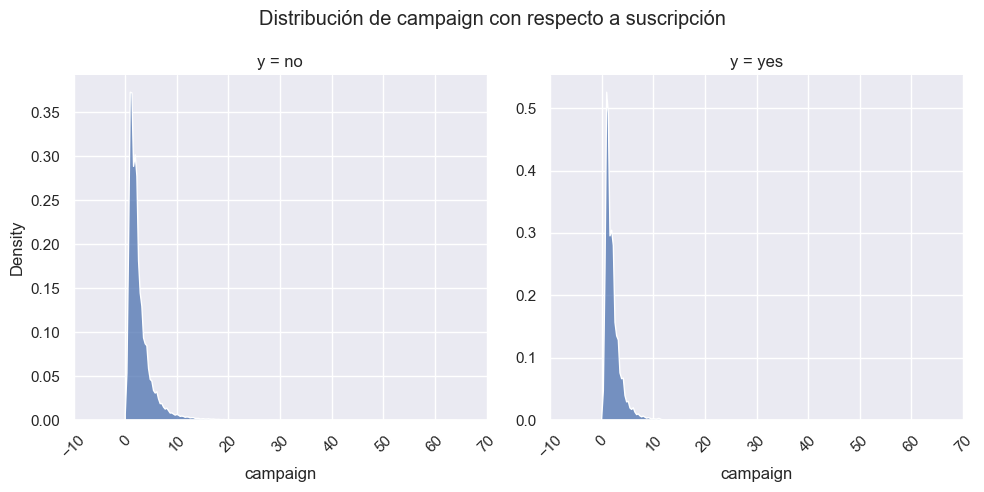

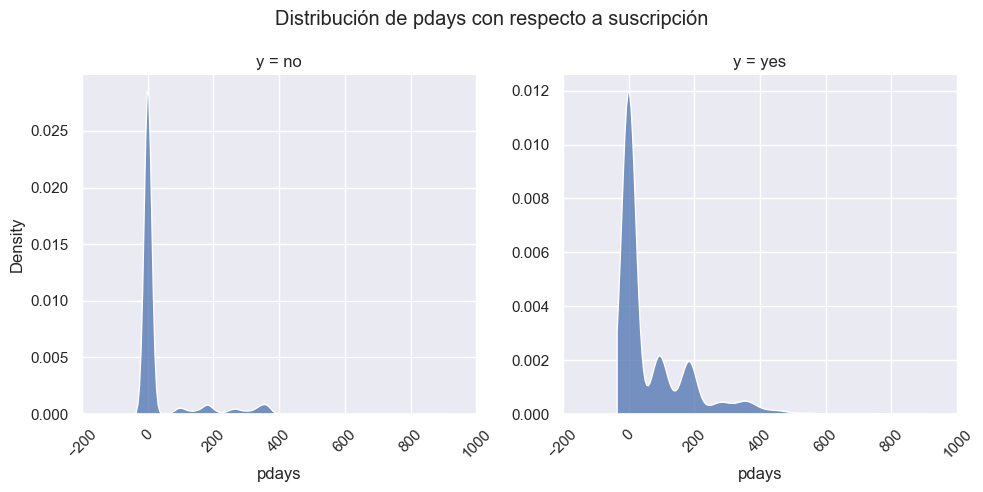

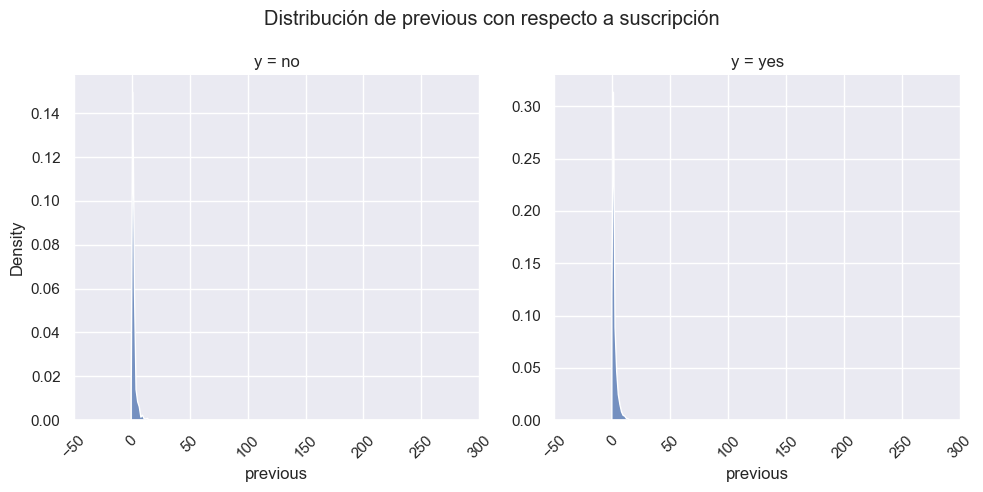

In [79]:
# Seleccionar columnas numéricas sin la columna objetivo
numerical_columns = [col for col in numerical_columns if col != 'y']

# Loop por cada columna para crear los displot
for column in numerical_columns:
    g = sns.displot(data=df,x=column,col='y',palette='coolwarm',facet_kws={"sharex": False,"sharey": False}, kind="kde", multiple="stack",fill=True,common_norm=False)
    g.fig.suptitle(f'Distribución de {column} con respecto a suscripción')
    g.set_xticklabels(rotation=45)

    plt.tight_layout()
    plt.show()


## 2. Construcción del modelo analítico

### A continuación se probara un conjunto de algoritmos para el entrenamiento del modelo y se utilizará la metrica de decision la curva PR dado que estamos ante un caso de datos desbalanceados.

### Asi mismo, se realizará una partición de los datos de 70-30. 70% para entrenamiento y 30% para pruebas.

### Tambien se incluira dentro del pipeline de entrenamiento un OneHotEnconder para binarizar las variables categoricas dado que por un lado algunos algoritmos no aceptan variables de este tipo y porque se puede obtener mejor performance al momento de entrenar el modelo con vectores densos o binarios. Y un escalado de las variables numericas continuar para evitar el overfitting en el modelo

In [13]:
# Se convierte en una varibale dummy antes de la separación 
df['y'] = df['y'].map({'no': 0, 'yes': 1})
# Separar características y variable objetivo
X = df.drop('y', axis=1)
y = df['y']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Identificacion de variables numéricas y categóricas
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

In [15]:
# Pipeline para variables categóricas
categorical_pipeline = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pipeline para variables numéricas
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', VarianceThreshold(threshold=0.01))
])

In [16]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [22]:
# Definición de los modelos a evaluar
modelos = {
    'Regresión Logística': LogisticRegression(max_iter=1000),
    'Árbol de Decisión': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'SVM': SVC(probability=True),
    'Red Neuronal': MLPClassifier(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Ridge Classifier': RidgeClassifier(),
    'SGD Classifier': SGDClassifier(loss='log_loss', max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Hist Gradient Boosting': HistGradientBoostingClassifier()
}

In [23]:
# Define hiperparámetros
parametros = {
    'Regresión Logística': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    'Árbol de Decisión': {
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
        'classifier__bootstrap': [True, False]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [-1, 10, 20],
        'classifier__num_leaves': [31, 50, 100]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    'Red Neuronal': {
        'classifier__hidden_layer_sizes': [(100,), (50, 50), (100, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__alpha': [0.0001, 0.001]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Naive Bayes': {
        'classifier__var_smoothing': [1e-09, 1e-08, 1e-07]
    },
    'Ridge Classifier': {
        'classifier__alpha': [0.1, 1.0, 10.0],
        'classifier__solver': ['auto', 'sag', 'saga']
    },
    'SGD Classifier': {
        'classifier__loss': ['log_loss', 'hinge'],
        'classifier__penalty': ['l2', 'l1', 'elasticnet'],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        'classifier__learning_rate': ['optimal', 'invscaling', 'adaptive']
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 6, 10],
        'classifier__subsample': [0.7, 1.0],
        'classifier__colsample_bytree': [0.7, 1.0]
    },
    'CatBoost': {
        'classifier__iterations': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__depth': [4, 6, 10]
    },
    'Hist Gradient Boosting': {
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_iter': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__l2_regularization': [0, 1.0]
    }
}

Evaluando modelo: Regresión Logística


Evaluando modelo: Árbol de Decisión
Evaluando modelo: Random Forest
Evaluando modelo: LightGBM
[LightGBM] [Info] Number of positive: 2952, number of negative: 22365
[LightGBM] [Info] Number of positive: 2953, number of negative: 22365
[LightGBM] [Info] Number of positive: 2953, number of negative: 22364
[LightGBM] [Info] Number of positive: 2953, number of negative: 22365
[LightGBM] [Info] Number of positive: 2953, number of negative: 22365
[LightGBM] [Info] Number of positive: 2953, number of negative: 22364
[LightGBM] [Info] Number of positive: 2952, number of negative: 22365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough

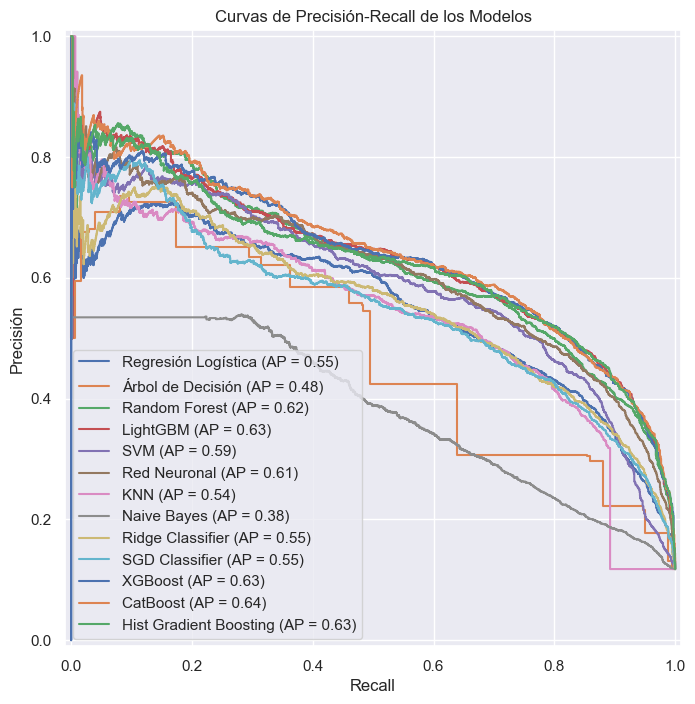


🟢 Mejor modelo: <catboost.core.CatBoostClassifier object at 0x12130e630>
🔢 Average Precision (AP): 0.6415


In [25]:
# Inicializar variables
mejor_modelo = None
mejor_ap = 0

# Crear figura
plt.figure(figsize=(12, 8))

# Evaluar cada modelo
for nombre, modelo in modelos.items():
    print(f"Evaluando modelo: {nombre}")

    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])

    # Hacer grid search con CV
    grid = GridSearchCV(pipeline, param_grid=parametros[nombre], cv=5, scoring='average_precision', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Obtener puntajes
    if hasattr(grid.best_estimator_['classifier'], 'predict_proba'):
        y_scores = grid.best_estimator_.predict_proba(X_test)[:, 1]
    else:
        y_scores = grid.best_estimator_.decision_function(X_test)

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)

    # Graficar curva PR
    disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name=nombre)
    disp.plot(ax=plt.gca())

    # Guardar mejor modelo
    if ap > mejor_ap:
        mejor_ap = ap
        mejor_modelo = grid.best_estimator_

# Mostrar resultados
plt.title('Curvas de Precisión-Recall de los Modelos')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Mostrar mejor modelo
print(f'\n🟢 Mejor modelo: {mejor_modelo.named_steps["classifier"]}')
print(f'🔢 Average Precision (AP): {mejor_ap:.4f}')


### Como se puede observar en la grafica el mejor modelo fue el CatBoost. Sin embargo, se pdria hacer fine tunning de hiperparametroz para mejorar sus performance. 

In [34]:
# Pipeline 
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'eval_metric': 'PRAUC',
        'loss_function': 'Logloss',
        'verbose': 0,
        'allow_writing_files': False
    }

    model = CatBoostClassifier(**params)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=3,
        scoring='average_precision'
    ).mean()

# 6. Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 7. Mostrar mejores resultados
print("🏆 Best params:", study.best_params)
print("✅ Best AP score:", study.best_value)

# 8. Entrenar modelo final con mejores hiperparámetros
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(**study.best_params))
])
final_model.fit(X_train, y_train)

# 9. Evaluación en test
y_pred = final_model.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, y_pred)
print(f"🎯 Average Precision en test: {ap:.4f}")

[I 2025-06-24 09:46:08,473] A new study created in memory with name: no-name-ff3753c7-28d0-49ed-840b-bb58824a6f31
[I 2025-06-24 09:46:20,712] Trial 0 finished with value: 0.6196704971484422 and parameters: {'iterations': 162, 'learning_rate': 0.038926848266665565, 'depth': 10, 'l2_leaf_reg': 1.8312830491738317, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6196704971484422.
[I 2025-06-24 09:46:25,580] Trial 1 finished with value: 0.614785937946769 and parameters: {'iterations': 229, 'learning_rate': 0.06343868901131476, 'depth': 4, 'l2_leaf_reg': 8.29840030655517, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6196704971484422.
[I 2025-06-24 09:46:34,313] Trial 2 finished with value: 0.6068315138151914 and parameters: {'iterations': 268, 'learning_rate': 0.016419694099401777, 'depth': 7, 'l2_leaf_reg': 9.794081964508127, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6196704971484422.
[I 2025-06-24 09:47:03,529] Trial 3 finished with value:

🏆 Best params: {'iterations': 401, 'learning_rate': 0.044536730057586835, 'depth': 7, 'l2_leaf_reg': 6.910331805355961, 'bootstrap_type': 'Bayesian'}
✅ Best AP score: 0.6286648491436215
0:	learn: 0.6354986	total: 6ms	remaining: 2.4s
1:	learn: 0.5879031	total: 12.3ms	remaining: 2.46s
2:	learn: 0.5468155	total: 19.2ms	remaining: 2.55s
3:	learn: 0.5081935	total: 30.6ms	remaining: 3.04s
4:	learn: 0.4772726	total: 38.4ms	remaining: 3.04s
5:	learn: 0.4479976	total: 45ms	remaining: 2.96s
6:	learn: 0.4262012	total: 51ms	remaining: 2.87s
7:	learn: 0.4050306	total: 58.5ms	remaining: 2.87s
8:	learn: 0.3863696	total: 65ms	remaining: 2.83s
9:	learn: 0.3678127	total: 71.1ms	remaining: 2.78s
10:	learn: 0.3546585	total: 76.5ms	remaining: 2.71s
11:	learn: 0.3421990	total: 87.3ms	remaining: 2.83s
12:	learn: 0.3333113	total: 92.5ms	remaining: 2.76s
13:	learn: 0.3238128	total: 98.3ms	remaining: 2.72s
14:	learn: 0.3137991	total: 104ms	remaining: 2.68s
15:	learn: 0.3037793	total: 109ms	remaining: 2.63s
16:	

### Como en este caso no se observa una mejoria con el Grid Search para el CatBoost (que hasta el momento sigue siendo el mejor algoritmo) se probara un paso de feature engineering deonde las variables categoricas actuales al tener una amplia apertura de labels se puede realizar una simplificación de estos labels siempre y cuando aplique. Como se observa en el siguiente resumen:

### Para el tipo de empleo se hara una simplificación donde se recategorizará entre empleados y desempleados: la categoria de desempleo contendra a los desempleados, los estudiantes y de quienes no se tiene información; los demas seran empleados. Donde en este caso en particular, se asume que quienes estan empleados reciben altun tipo de ingreso y por lo tanto tiene algun tipo de saldo. 

### Así mismo, para el estado civil se recategoriza con una simplificación entre casados y solteros. Y para esto se asumira que quienes estan divorciados estan solteros. 

In [63]:
for column in categorical_columns:
    counts = tmp[column].value_counts()
    percentages = tmp[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({
        'Frecuencia': counts,
        'Porcentaje (%)': percentages.round(2)
    })

    display(Markdown(f"### Distribución de valores para **{column}**"))
    display(summary)

### Distribución de valores para **job**

,Frecuencia,Porcentaje (%)
job,,
management,1301,24.60
technician,840,15.88
blue-collar,708,13.39
admin.,631,11.93
retired,516,9.76
services,369,6.98
student,269,5.09
unemployed,202,3.82
self-employed,187,3.54


### Distribución de valores para **marital**

,Frecuencia,Porcentaje (%)
marital,,
married,2755,52.09
single,1912,36.15
divorced,622,11.76


### Distribución de valores para **education**

,Frecuencia,Porcentaje (%)
education,,
secondary,2450,46.32
tertiary,1996,37.74
primary,591,11.17
unknown,252,4.76


### Distribución de valores para **default**

,Frecuencia,Porcentaje (%)
default,,
no,5237,99.02
yes,52,0.98


### Distribución de valores para **housing**

,Frecuencia,Porcentaje (%)
housing,,
no,3354,63.41
yes,1935,36.59


### Distribución de valores para **loan**

,Frecuencia,Porcentaje (%)
loan,,
no,4805,90.85
yes,484,9.15


### Distribución de valores para **contact**

,Frecuencia,Porcentaje (%)
contact,,
cellular,4369,82.61
unknown,530,10.02
telephone,390,7.37


### Distribución de valores para **month**

,Frecuencia,Porcentaje (%)
month,,
may,925,17.49
aug,688,13.01
jul,627,11.85
apr,577,10.91
jun,546,10.32
feb,441,8.34
nov,403,7.62
oct,323,6.11
sep,269,5.09


### Distribución de valores para **poutcome**

,Frecuencia,Porcentaje (%)
poutcome,,
unknown,3386,64.02
success,978,18.49
failure,618,11.68
other,307,5.80


In [66]:
# Crear un diccionario de reemplazo
reemplazos_job = {
    'management': 'employed'
    ,'technician': 'employed'
    ,'blue-collar': 'employed'
    ,'admin.': 'employed'
    ,'retired': 'employed'
    ,'services'	: 'employed'
    ,'student': 'unemployed'
    ,'self-employed': 'employed'
    ,'entrepreneur': 'employed'
    ,'housemaid': 'employed'
    ,'unknown': 'unemployed'
}

# Reemplazar en la columna job
df['job'] = df['job'].replace(reemplazos_job)

In [68]:
# Crear un diccionario de reemplazo
reemplazos_marital = {
    'divorced': 'single'
}

# Reemplazar en la columna marital
df['marital'] = df['marital'].replace(reemplazos_marital)

In [72]:
X = df.drop('y', axis=1)
y = df['y']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

[I 2025-06-24 15:44:41,547] A new study created in memory with name: no-name-e251cd4b-97ec-45d4-af5b-c3579a8d5d6f
[I 2025-06-24 15:44:52,655] Trial 0 finished with value: 0.6237614595853446 and parameters: {'iterations': 246, 'learning_rate': 0.04050969299814228, 'depth': 9, 'l2_leaf_reg': 8.853546083098255, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6237614595853446.
[I 2025-06-24 15:44:56,864] Trial 1 finished with value: 0.6189638032772887 and parameters: {'iterations': 145, 'learning_rate': 0.27654798590956997, 'depth': 5, 'l2_leaf_reg': 7.042032885849018, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6237614595853446.
[I 2025-06-24 15:45:02,760] Trial 2 finished with value: 0.5899519856272993 and parameters: {'iterations': 339, 'learning_rate': 0.014077523392026087, 'depth': 4, 'l2_leaf_reg': 4.78362317905421, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.6237614595853446.
[I 2025-06-24 15:45:12,779] Trial 3 finished with value: 0

🏆 Best params: {'iterations': 448, 'learning_rate': 0.04644050194399947, 'depth': 8, 'l2_leaf_reg': 6.392732133063632, 'bootstrap_type': 'MVS'}
✅ Best AP score: 0.6304875612357562
0:	learn: 0.6342463	total: 5.62ms	remaining: 2.51s
1:	learn: 0.5812106	total: 15.1ms	remaining: 3.37s
2:	learn: 0.5376325	total: 26.2ms	remaining: 3.89s
3:	learn: 0.4996008	total: 35.9ms	remaining: 3.99s
4:	learn: 0.4647166	total: 45.4ms	remaining: 4.02s
5:	learn: 0.4369077	total: 57.6ms	remaining: 4.24s
6:	learn: 0.4142452	total: 68.6ms	remaining: 4.32s
7:	learn: 0.3916427	total: 76.8ms	remaining: 4.22s
8:	learn: 0.3704117	total: 86.7ms	remaining: 4.23s
9:	learn: 0.3545298	total: 95.1ms	remaining: 4.17s
10:	learn: 0.3420788	total: 103ms	remaining: 4.08s
11:	learn: 0.3292797	total: 112ms	remaining: 4.07s
12:	learn: 0.3190664	total: 121ms	remaining: 4.05s
13:	learn: 0.3099362	total: 130ms	remaining: 4.03s
14:	learn: 0.3007691	total: 142ms	remaining: 4.11s
15:	learn: 0.2930552	total: 153ms	remaining: 4.12s
16:	

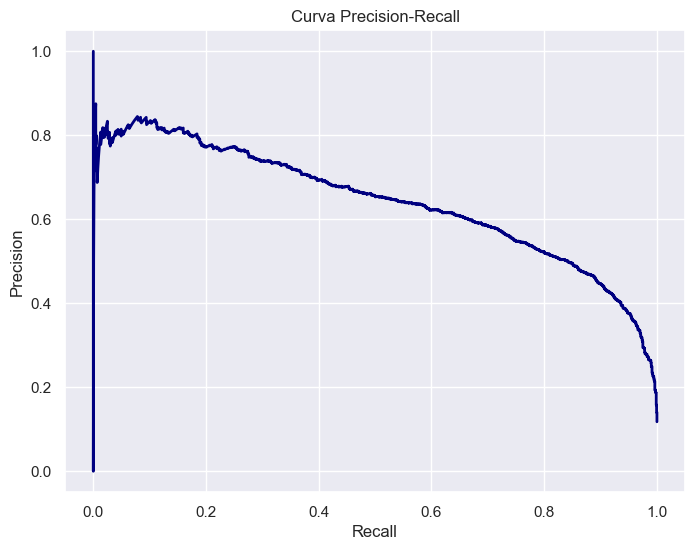

In [73]:
# Pipeline 
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'eval_metric': 'PRAUC',
        'loss_function': 'Logloss',
        'verbose': 0,
        'allow_writing_files': False
    }

    model = CatBoostClassifier(**params)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=3,
        scoring='average_precision'
    ).mean()

# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Mostrar mejores resultados
print("🏆 Best params:", study.best_params)
print("✅ Best AP score:", study.best_value)

# Entrenar modelo final con mejores hiperparámetros
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(**study.best_params))
])
final_model.fit(X_train, y_train)

# Evaluación en test
y_pred = final_model.predict_proba(X_test)[:, 1]
ap = average_precision_score(y_test, y_pred)
print(f"🎯 Average Precision en test: {ap:.4f}")

# Curva Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='navy', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
print(f'🔢 Average Precision (AP): {ap:.4f}')
plt.grid(True)
plt.show()

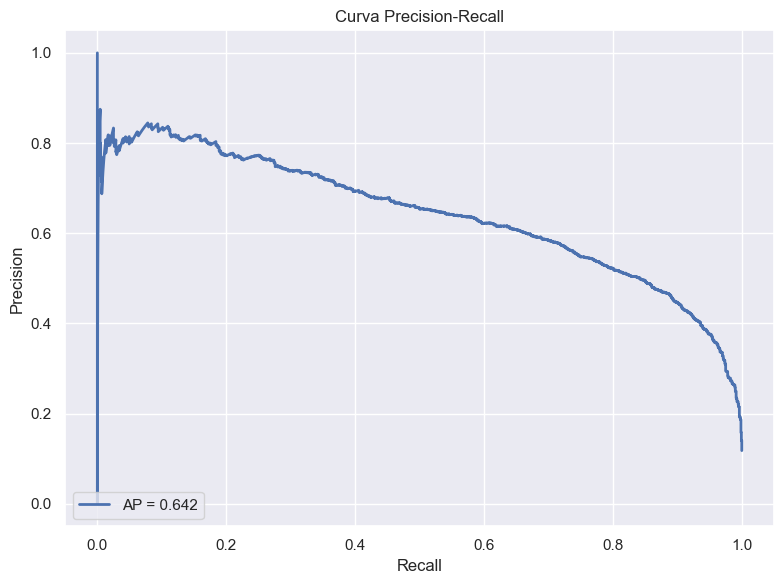

In [79]:
# Graficar
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()